<a href="https://colab.research.google.com/github/SLVmain/Deep_Learning/blob/main/HW_21_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Задание Ultra pro

Взяв за основу практический ноутбук занятия, постройте трансформер для задачи question answering. Трансформер должен на вход принимать какой-то вопрос, а на выходе генерировать ответ на этот вопрос. Можно использовать любую базу для задачи question answering из tensorflow_datasets, например 'web_questions'.

In [ ]:
from google.colab import files 
import tensorflow as tf 
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, GlobalMaxPooling1D, LSTM, GRU, Bidirectional, Embedding, Input, Concatenate, Attention
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker 
from sklearn.model_selection import train_test_split 
from tensorflow.keras.utils import to_categorical, plot_model
import re 
import time
import os 
import gdown

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
examples, metadata = tfds.load('web_questions', 
                               with_info=True,                 
                               )           

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/web_questions/1.0.0.incompleteU6WTVN/web_questions-train.tfrecord


  0%|          | 0/3778 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/web_questions/1.0.0.incompleteU6WTVN/web_questions-test.tfrecord


  0%|          | 0/2032 [00:00<?, ? examples/s]

Dataset web_questions downloaded and prepared to /root/tensorflow_datasets/web_questions/1.0.0. Subsequent calls will reuse this data.


In [ ]:
metadata

tfds.core.DatasetInfo(
    name='web_questions',
    version=1.0.0,
    description='This dataset consists of 6,642 question/answer pairs.
The questions are supposed to be answerable by Freebase, a large knowledge graph.
The questions are mostly centered around a single named entity.
The questions are popular ones asked on the web (at least in 2013).',
    homepage='https://worksheets.codalab.org/worksheets/0xba659fe363cb46e7a505c5b6a774dc8a',
    features=FeaturesDict({
        'answers': Sequence(Text(shape=(), dtype=tf.string)),
        'question': Text(shape=(), dtype=tf.string),
        'url': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=5810,
    splits={
        'test': 2032,
        'train': 3778,
    },
    supervised_keys=None,
    citation="""@inproceedings{berant-etal-2013-semantic,
        title = "Semantic Parsing on {F}reebase from Question-Answer Pairs",
        author = "Berant, Jonathan  and
          Chou, Andrew  and
          Frostig, Roy  and
  

In [ ]:
# Разделяем на обучающую и тестовую выборки
train_examples, val_examples = examples['train'], examples['test'] 

In [ ]:
# Выведем первые 5 пар предложений str(full['question'].numpy(), encoding='UTF-8'))
for example in train_examples.take(5):
  answers, question, __ = example['answers'].numpy(), example["question"].numpy(), example["url"]
  print(answers)
  print(question)
  print('------------------------------------------------')

[b'Joe Flacco']
b'who is the ravens quarterback 2012?'
------------------------------------------------
[b'Whig Party']
b'what political party was henry clay?'
------------------------------------------------
[b'UTC+07:00']
b'where to stay in thailand koh samui?'
------------------------------------------------
[b'Bahrain' b'Afghanistan' b'Bangladesh' b'Bhutan' b'Brunei' b'Indonesia'
 b'India' b'Cambodia' b'China' b'Iraq']
b'what countries are included in the continent of asia?'
------------------------------------------------
[b'Murder Was the Case' b'Above the Rim' b'Bullet' b'Gang Related'
 b'Watch Juice' b'Tupac: Live at the House of Blues'
 b'Nothing but Trouble' b'Juice' b'Poetic Justice' b"Gridlock'd"]
b'what movies does tupac act in?'
------------------------------------------------


In [ ]:
# создаем токенайзер на вопросах
tokenizer_qw = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (example["question"].numpy() for example in train_examples), target_vocab_size=2**13)

In [ ]:
# Тестовая фраза
sample_string = 'Transformer is complicated.' 

# Перегоним слова в токены
tokenized_string = tokenizer_qw.encode(sample_string) 
print('Tokenized string is {}'.format(tokenized_string))

# Перегоним токены обратно в слова
original_string = tokenizer_qw.decode(tokenized_string) 
print('The original string: {}'.format(original_string))

# Распишем какой токен чему соответсвует
for ts in tokenized_string:
  print('{} ----> {}'.format(ts, tokenizer_qw.decode([ts]))) 

# А точно ли исходная фраза соответствует дважды перекодированной?
print(original_string == sample_string)

Tokenized string is [4341, 4371, 4354, 4367, 4372, 3446, 3, 1768, 4366, 4369, 4365, 4362, 438, 4373, 4358, 4357, 4303]
The original string: Transformer is complicated.
4341 ----> T
4371 ----> r
4354 ----> a
4367 ----> n
4372 ----> s
3446 ----> former 
3 ----> is 
1768 ----> co
4366 ----> m
4369 ----> p
4365 ----> l
4362 ----> i
438 ----> ca
4373 ----> t
4358 ----> e
4357 ----> d
4303 ----> .
True


In [ ]:
#train_ex = train_examples

In [ ]:
def encode(qw, an):

  # Добавление токенов start и end 
  question = [tokenizer_qw.vocab_size] + tokenizer_qw.encode(
      str(qw.numpy())) + [tokenizer_qw.vocab_size+1]      # нужно обернуть в str
  
  # Добавление токенов start и end 
  answers = [tokenizer_qw.vocab_size] + tokenizer_qw.encode(
      str(an.numpy())) + [tokenizer_qw.vocab_size+1]
  
  return question, answers

In [ ]:
# Обертка над предыдущей функцией encode()
def tf_encode(examples):
  ex = examples
  result_qw, result_an = tf.py_function(encode,               # Функция
                                        [ex['question'],        # Аргументы 
                                          ex['answers']],             # Аргументы 
                                        [tf.int64, tf.int64]) # Типы данных
  result_qw.set_shape([None])
  result_an.set_shape([None])

  return result_qw, result_an

In [ ]:
# Размер буфера в памяти при подготовке датасета
BUFFER_SIZE = 20000 

# Размер батча
BATCH_SIZE = 64  

# Максимальная длина фраз
MAX_LENGTH = 40  

In [ ]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
    
  return tf.logical_and(tf.size(x) <= max_length, # Маска для значений x
                        tf.size(y) <= max_length) # Маска для значений y

In [ ]:
# Прогоняем обучающие тексты через токенайзер
# Благодаря .map мы применим функцию tf_encode к каждому примеру выборки
train_dataset = train_examples.map(tf_encode) 

# Фильтруем по максимальной длинне
train_dataset = train_dataset.filter(filter_max_length) 

# Кэшируем данные в память для ускорения работы
train_dataset = train_dataset.cache() 

# Делим на батчи и перемешиваем
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE) 

# # .prefetch используется для разделения времени, когда данные производятся, 
# от времени, когда данные потребляются. Это ускоряет обучение сети
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE) 

# Прогоняем проверочные тексты через токенайзер
val_dataset = val_examples.map(tf_encode)

# Фильтруем по максимальной длинне
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

In [ ]:
# Возьмем первый батч датасета
question_batch, answers_batch = next(iter(val_dataset))

# Посмотрим что внутри
question_batch, answers_batch

(<tf.Tensor: shape=(64, 27), dtype=int64, numpy=
 array([[4513, 4355, 4296, ...,    0,    0,    0],
        [4513, 4355, 4296, ...,    0,    0,    0],
        [4513, 4355, 4296, ...,    0,    0,    0],
        ...,
        [4513, 4355, 4296, ...,    0,    0,    0],
        [4513, 4355, 4296, ...,    0,    0,    0],
        [4513, 4355, 4296, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(64, 39), dtype=int64, numpy=
 array([[4513, 4348, 4355, ...,    0,    0,    0],
        [4513, 4348, 4355, ...,    0,    0,    0],
        [4513, 4348, 4355, ...,    0,    0,    0],
        ...,
        [4513, 4348, 4355, ...,    0,    0,    0],
        [4513, 4348, 4355, ...,    0,    0,    0],
        [4513, 4348, 4355, ...,    0,    0,    0]])>)

In [ ]:
def get_angles(pos, i, d_model):

  # По формуле рассчитаем аргументы позиционного кодирования
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [ ]:
def positional_encoding(position, d_model):
  
  # Получаем аргументы
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # Чётные индексы будут принимать значение от sin
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # Нечётные индексы будут принимать значение от cos
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  # Добавляем ещё одну размерность
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

Пишем класс MultiHeadAttention. Писать слои attention своими руками не будем, используем готовый слой Attention из модуля keras (`tf.keras.layers.Attention(use_scale=False, **kwargs))`

Принимает на вход список из наших знакомых `Query, Value, Key`
На выходе вектор внимания той же размерности.



In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, 
               d_model = 512, # Размерность емб. пространства
               num_heads = 8, # Количество голов сети
               causal=False,  # Применять маску в Attention или нет
               dropout=0.0):  # Значение Dropout

    super(MultiHeadAttention, self).__init__()  # Здесь все головы считаем паралелльно - поэтому attention пробегает и по батчу и по числу голов

    assert d_model % num_heads == 0 # Проверим, что размерность головы - целое цисло
    depth = d_model // num_heads    # Размерность каждой головы внимания  =>>  multi-headed_depth = depth / num_heads
                                    # Заметим, что выходы голов конкатенируются, поэтому их размер в их число раз меньше.
                                    # Поэтому размерность выхода должно совпасть в размерностью входа

    self.w_query = tf.keras.layers.Dense(d_model)                            # Dense для Query  (batch_size , seq_length, depth) 
    self.split_reshape_query = tf.keras.layers.Reshape((-1,num_heads,depth)) # Слой для решейпа query до (batch_size , seq_length, num_heads, multi_headed_depth)  
    self.split_permute_query = tf.keras.layers.Permute((2,1,3))              # Слой для перестановки размерностей для использования Attention

    self.w_value = tf.keras.layers.Dense(d_model)                            # Dense для Value  (batch_size , seq_length, depth)
    self.split_reshape_value = tf.keras.layers.Reshape((-1,num_heads,depth)) # Слой для решейпа value до (batch_size , seq_length, num_heads, multi_headed_depth
    self.split_permute_value = tf.keras.layers.Permute((2,1,3))              # Слой для перестановки размерностей для использования Attention

    self.w_key = tf.keras.layers.Dense(d_model)                              # Dense для Key  (batch_size , seq_length, depth)
    self.split_reshape_key = tf.keras.layers.Reshape((-1,num_heads,depth))   # Слой для решейпа key до (batch_size , seq_length, num_heads, multi_headed_depth
    self.split_permute_key = tf.keras.layers.Permute((2,1,3))                # Слой для перестановки размерностей для использования Attention

    self.attention = tf.keras.layers.Attention(causal=causal, dropout=dropout) # Прописываем слой Attention
    self.join_permute_attention = tf.keras.layers.Permute((2,1,3))             # Слой обратной перестановки размерностей
    self.join_reshape_attention = tf.keras.layers.Reshape((-1,d_model))        # Слой обратного решейпа до размернсти модели

    self.dense = tf.keras.layers.Dense(d_model)     # Полносвязный слой

  def call(self, inputs, mask=None, training=None): # Основная рабочая функция

    q = inputs[0]                           # Вытащим входной вектор Query
    v = inputs[1]                           # Вытащим входной вектор Value
    k = inputs[2] if len(inputs) > 2 else v # Вытащим входной вектор Key

    query = self.w_query(q)                   # Прогоним через dense
    query = self.split_reshape_query(query)   # Решейпим
    query = self.split_permute_query(query)   # Переставляем размерность

    value = self.w_value(v)                 # Прогоним через dense
    value = self.split_reshape_value(value) # Решейпим
    value = self.split_permute_value(value) # Переставляем размерность

    key = self.w_key(k)               # Прогоним через dense
    key = self.split_reshape_key(key) # Решейпим
    key = self.split_permute_key(key) # Переставляем размерность

    if mask is not None: # Применим маску если есть 

      if mask[0] is not None:
        mask[0] = tf.keras.layers.Reshape((-1,1))(mask[0])     # Слой для решейпа
        mask[0] = tf.keras.layers.Permute((2,1))(mask[0])      # Слой для перестановки размерностей
      
      if mask[1] is not None:
        mask[1] = tf.keras.layers.Reshape((-1,1))(mask[1])     # Слой для решейпа
        mask[1] = tf.keras.layers.Permute((2,1))(mask[1])      # Слой для перестановки размерностей

    attention = self.attention([query, value, key], mask=mask) # Вычисляем вектор внимания
    attention = self.join_permute_attention(attention)         # Обратно перемешиваем размерности
    attention = self.join_reshape_attention(attention)         # Решейпим до (batch_size , seq_length, depth) 

    x = self.dense(attention) # Выходной dense

    return x

Определим класс кодера. Он содержит один слой "многоголовое внимание", дропаут, слой сложения - создает resudial связь, слой нормализации и Feed Forward блок - в dense слоя.

In [ ]:
class EncoderLayer(tf.keras.layers.Layer): 

  def __init__(self,  
               d_model = 512,  # Размерность емб. пространства
               num_heads = 8,  # Количество голов сети
               dff = 2048,     # Количество нейронов первого Dense слоя
               dropout = 0.0): # Значение Dropout
    
    super(EncoderLayer, self).__init__()

    self.multi_head_attention = MultiHeadAttention(d_model, num_heads)   # Определим слой  MultiHeadAttention
    self.dropout_attention = tf.keras.layers.Dropout(dropout)            # Добавим дропаут
    self.add_attention = tf.keras.layers.Add()                           # Слой для получения resudial связи
    self.layer_norm_attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)  # Слой нормализации

    self.dense1 = tf.keras.layers.Dense(dff, activation='relu')               # Первый dense в Feed Forward
    self.dense2 = tf.keras.layers.Dense(d_model)                              # Второй  dense в Feed Forward
    self.dropout_dense = tf.keras.layers.Dropout(dropout)                     # Добавим дропаут
    self.add_dense = tf.keras.layers.Add()                                    # Слой для получения resudial связи
    self.layer_norm_dense = tf.keras.layers.LayerNormalization(epsilon=1e-6)  # Слой нормализации

  def call(self, inputs, mask=None, training=None):

    # Входной вектор input размножим до 3 - это query, value, key и отдадим attenton, с маской если есть 
    attention = self.multi_head_attention([inputs,inputs,inputs], mask = [mask,mask]) 
    
    # Уменьшим переобучение дроаутом
    attention = self.dropout_attention(attention, training = training) 
    
    # Сделаем resudial связь - добавим входной вектор
    x = self.add_attention([inputs , attention]) 
    
    # Далее нормализация в масштабах уровня
    x = self.layer_norm_attention(x)  

    # Добавим Feed Forward  
    # Проходим 1й dense с активашкой relu
    dense = self.dense1(x) 
    
    # Второй dense без активашки т.е. с линейной активационной функцией
    dense = self.dense2(dense)  
    
    # Добавляем дропаут
    dense = self.dropout_dense(dense, training = training)  
    
    # Еще одна resudial связь
    x = self.add_dense([x , dense])  
    
    # Нормализация в масштабах уровня
    x = self.layer_norm_dense(x)  

    return x

Определим класс слой декодера, который содержит один слой "многоголовое внимание", дропаут, слой сложения - создает resudial связь, слой нормализации и Feed Forward блок - в dense слоя:

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):

  def __init__(self,  
               d_model = 512,  # Размерность емб. пространства
               num_heads = 8,  # Количество голов сети
               dff = 2048,     # Количество нейронов первого Dense слоя
               dropout = 0.0): # Значение Dropout

    super(DecoderLayer, self).__init__()

    self.multi_head_attention1 =  MultiHeadAttention(d_model, num_heads, causal = True) # Определим слой  MultiHeadAttention
    self.dropout_attention1 = tf.keras.layers.Dropout(dropout)                          # Добавим дропаут
    self.add_attention1 = tf.keras.layers.Add()                                         # Слой для получения resudial связи
    self.layer_norm_attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)       # Слой нормализации

    self.multi_head_attention2 =  MultiHeadAttention(d_model, num_heads)                # Определим слой  MultiHeadAttention 
    self.dropout_attention2 = tf.keras.layers.Dropout(dropout)                          # Добавим дропаут
    self.add_attention2 = tf.keras.layers.Add()                                         # Слой для получения resudial связи
    self.layer_norm_attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)       # Слой нормализации


    self.dense1 = tf.keras.layers.Dense(dff, activation='relu')                         # Первый dense в Feed Forward
    self.dense2 = tf.keras.layers.Dense(d_model)                                        # Второй  dense в Feed Forward
    self.dropout_dense = tf.keras.layers.Dropout(dropout)                               # Добавим дропаут
    self.add_dense = tf.keras.layers.Add()                                              # Слой для получения resudial связи
    self.layer_norm_dense = tf.keras.layers.LayerNormalization(epsilon=1e-6)            # Слой нормализации

  def call(self, inputs, mask=None, training=None):
    
    # Подадим на multi-head attention  Query, Key, Value вектора - здесь это один и тот же вектор
    attention = self.multi_head_attention1([inputs[0],inputs[0],inputs[0]], mask = [mask[0],mask[0]])
    
    # Пробежим дропаут
    attention = self.dropout_attention1(attention, training = training)
    
    # Пробросим Resudial-связь
    x = self.add_attention1([inputs[0] , attention])
    
    # Выполним нормализацию
    x = self.layer_norm_attention1(x)
    
    # Второй multi-head attention. Подаем выход предыдущих слоев x и выход от энкодера, маску (если есть)
    attention = self.multi_head_attention2([x, inputs[1],inputs[1]], mask = [mask[0],mask[1]])
    
    # Прогоняем через дропаут
    attention = self.dropout_attention2(attention, training = training)
    
    # Пробросим Resudial-связь
    x = self.add_attention1([x , attention])
    
    # Выполним нормализацию
    x = self.layer_norm_attention1(x)

    # Feed Forward
    # 1 dense + relu
    dense = self.dense1(x)

    # 2 dense +linear
    dense = self.dense2(dense)

    # Прогоняем через дропаут
    dense = self.dropout_dense(dense, training = training)

    # Пробросим Resudial-связь
    x = self.add_dense([x , dense])

    # Выполним нормализацию
    x = self.layer_norm_dense(x)

    return x

Создаем сам кодер из слоев, описанных ранее (embedding, позиционное кодирование, пачки кодеров):


In [ ]:
class Encoder(tf.keras.layers.Layer):

  def __init__(self, 
               input_vocab_size,                  # Размер словаря
               num_layers = 4,                    # Количество слоев энкодера
               d_model = 512,                     # Размерность емб. пространства
               num_heads = 8,                     # Количество голов сети
               dff = 2048,                        # Количество нейронов первого Dense слоя
               maximum_position_encoding = 10000, # Максимальное число позиций
               dropout = 0.0):                    # Значение Dropout
    
    super(Encoder, self).__init__()

    self.d_model = d_model

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, # Пропишем слой Embedding
                                               d_model, 
                                               mask_zero=True)  
    
    self.pos = positional_encoding(maximum_position_encoding,    # Функция позиционного кодирования
                                   d_model)   
                   
    self.encoder_layers = [ EncoderLayer(d_model = d_model,      # Список Nx слоев кодера
                                         num_heads = num_heads, 
                                         dff = dff, 
                                         dropout = dropout) for _ in range(num_layers)]  

    self.dropout = tf.keras.layers.Dropout(dropout)              # Просто дропаут

  def call(self, inputs, mask=None, training=None):
    
    # Входной эмбеддинг  
    x = self.embedding(inputs) 
    
    # Позиционное кодирование
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32)) 
    x += self.pos[: , :tf.shape(x)[1], :]
    
    # Прогоняем через дропаут
    x = self.dropout(x, training=training)

    # Входной слой embedding+ Позиционное кодирование
    embedding_mask = self.embedding.compute_mask(inputs)

    # Прогоним через Nx слоев кодера
    for encoder_layer in self.encoder_layers: 
      x = encoder_layer(x, mask = embedding_mask)

    return x

  # Закомментируйте код ниже, если хотите использовать masked_loss()
  def compute_mask(self, inputs, mask=None):
    return self.embedding.compute_mask(inputs)

Создаем сам декодер из слоев, описанных выше (embedding, позиционное кодирование, пачки декодеров):

In [ ]:
class Decoder(tf.keras.layers.Layer):

  def __init__(self, 
               target_vocab_size,                 # Размер словаря выходных данных
               num_layers = 4,                    # Количество слоев декодера
               d_model = 512,                     # Размерность емб. пространства
               num_heads = 8,                     # Количество голов сети
               dff = 2048,                        # Количество нейронов первого Dense слоя
               maximum_position_encoding = 10000, # Максимальное число позиций
               dropout = 0.0):                    # Значение Dropout
    
    super(Decoder, self).__init__()

    self.d_model = d_model

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, # Пропишем слой Embedding
                                               d_model, 
                                               mask_zero=True) 
    
    self.pos = positional_encoding(maximum_position_encoding,     # Функция позиционного кодирования
                                   d_model)                     

    self.decoder_layers = [ DecoderLayer(d_model = d_model, 
                                         num_heads = num_heads, 
                                         dff = dff, 
                                         dropout = dropout)  for _ in range(num_layers)] # Список Nx слоев декодера 

    self.dropout = tf.keras.layers.Dropout(dropout)               # Слой дропаут

  def call(self, inputs, mask=None, training=None):
    
    # Выполним переход в эмбеддинг
    x = self.embedding(inputs[0]) 
    
    # Позиционное кодирование
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos[: , :tf.shape(x)[1], :]
    
    # Просто dropout
    x = self.dropout(x, training=training)
    
    # Входной слой embedding + Позиционное кодирование
    embedding_mask = self.embedding.compute_mask(inputs[0])

    # Прогоним через Nx слоев декодера
    for decoder_layer in self.decoder_layers:
      x = decoder_layer([x,inputs[1]], mask = [embedding_mask, mask])

    return x

  # Закомментируйте код ниже, если хотите использовать masked_loss()
  def compute_mask(self, inputs, mask=None):
    return self.embedding.compute_mask(inputs[0])

Соберем модель: 2 входных слоя, кодер, декодер, 
выходной dense:

In [ ]:
num_layers = 4 # Количество слоев
d_model = 128  # Размерность емб. пространства
dff = 512      # Количество нейронов первого Dense слоя
num_heads = 8  # Количество голов

dropout_rate = 0.1 # Значение Dropout

input_vocab_size = tokenizer_qw.vocab_size + 2  # Индекс входного тега
target_vocab_size = tokenizer_qw.vocab_size + 2 # Индекс выходного тега


input  = tf.keras.layers.Input(shape=(None,)) # Входной слой для переводимой фразы
target = tf.keras.layers.Input(shape=(None,)) # Вход для перевода

encoder = Encoder(input_vocab_size,           # Создаем энкодер
                  num_layers = num_layers, 
                  d_model = d_model, 
                  num_heads = num_heads, 
                  dff = dff, 
                  dropout = dropout_rate)  

decoder = Decoder(target_vocab_size,          # Создаем декодер
                  num_layers = num_layers, 
                  d_model = d_model, 
                  num_heads = num_heads, 
                  dff = dff, 
                  dropout = dropout_rate) 

# Собираем модель 
x = encoder(input)
x = decoder([target, x] , mask = encoder.compute_mask(input))
x = tf.keras.layers.Dense(target_vocab_size)(x)

# Формируем модель, выводим саммери
model = tf.keras.models.Model(inputs=[input, target], outputs=x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 encoder (Encoder)              (None, None, 128)    1371008     ['input_1[0][0]']                
                                                                                                  
 tf.math.not_equal (TFOpLambda)  (None, None)        0           ['input_1[0][0]']                
                                                                                              

Проверим работоспособность:

(64, 39, 4515)

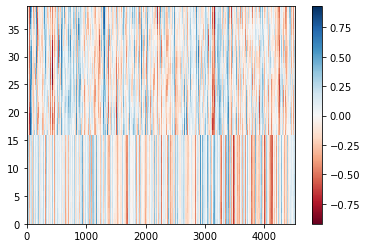

In [ ]:
# Возьмем пример данн
qw_batch, an_batch = next(iter(val_dataset))

# Выведем результат предсказания в виде тепловой карты
plt.pcolormesh(model.predict([qw_batch,an_batch])[5],cmap='RdBu')
plt.colorbar()

# Размерность предикта
model.predict([qw_batch,an_batch]).shape

Класс CustomSchedule предназначен для создания собственных параметров оптимизатора. 

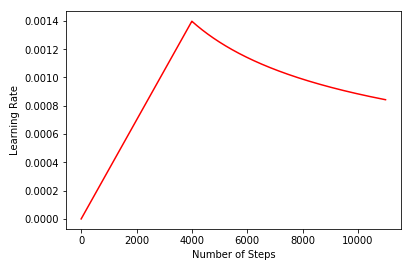

Этот подход называется "Прогрев" и благодаря такому изменению шага обучения, как изображен на графике выше, наш трансформер успешно обучается.

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Задаем оптимайзер, функцию потерь, метрики и компилируем модель

In [ ]:
# Оптимайзер 
optimizer = tf.keras.optimizers.Adam(CustomSchedule(d_model), 
                                     beta_1=0.9, 
                                     beta_2=0.98, 
                                     epsilon=1e-9)
# Функция потерь
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

# Мы рассчитываем потери, используя предопределенную целевую функцию, 
# а затем дополняем ее маской.

def masked_loss(y_true, y_pred):

  # Считаем маску  
  mask = tf.math.logical_not(tf.math.equal(y_true, 0))
  _loss = loss(y_true, y_pred)

  mask = tf.cast(mask, dtype=_loss.dtype)

  # Накинем маску на потери  
  _loss *= mask

  return tf.reduce_sum(_loss)/tf.reduce_sum(mask)

metrics = [loss, masked_loss, tf.keras.metrics.SparseCategoricalAccuracy()]

model.compile(optimizer=optimizer, loss = loss, metrics = metrics) # masked_

Проверим число батчей для обучения и проверки:

In [ ]:
# Количество батчей для обучения
num_batches = 0
for (batch, (_,_)) in enumerate(train_dataset):
  num_batches = batch
print(num_batches)

# Количество батчей для проверки
val_batches = 0
for (batch, (_,_)) in enumerate(val_dataset):
  val_batches = batch
print(val_batches)

44
23


Напишем генератор. По номеру будем получать батч данных для обучения, запустим обучение:

Функция generator() принимает на вход данные и посредством генератора (конструкции while_yeld) получает из данных по батчу на каждой итерации, при этом не заполняя память.

In [ ]:
def generator(data_set):
    
  while True:
    for qw_batch, an_batch in data_set:
      yield ( [qw_batch , an_batch[:, :-1] ] , an_batch[:, 1:] )

# При помощи генератора запускаем обучение
history = model.fit(x = generator(train_dataset),              # Данные для обучения
                    validation_data = generator(val_dataset),  # Данные для проверки
                    epochs=100,                                  # Количество эпох
                    steps_per_epoch = num_batches,             # Количество батчей
                    validation_steps = val_batches)            # Батчи на проверку

Epoch 1/100
44/44 [==============================] - 5s 111ms/step - loss: 0.3822 - sparse_categorical_crossentropy: 0.7344 - masked_loss: 0.7731 - sparse_categorical_accuracy: 0.7874 - val_loss: 1.1235 - val_sparse_categorical_crossentropy: 2.1527 - val_masked_loss: 2.2652 - val_sparse_categorical_accuracy: 0.5952
Epoch 2/100
44/44 [==============================] - 5s 112ms/step - loss: 0.3688 - sparse_categorical_crossentropy: 0.7050 - masked_loss: 0.7420 - sparse_categorical_accuracy: 0.7939 - val_loss: 1.1392 - val_sparse_categorical_crossentropy: 2.1829 - val_masked_loss: 2.2970 - val_sparse_categorical_accuracy: 0.5948
Epoch 3/100
44/44 [==============================] - 6s 136ms/step - loss: 0.3565 - sparse_categorical_crossentropy: 0.6911 - masked_loss: 0.7276 - sparse_categorical_accuracy: 0.7964 - val_loss: 1.1468 - val_sparse_categorical_crossentropy: 2.1974 - val_masked_loss: 2.3122 - val_sparse_categorical_accuracy: 0.5952
Epoch 4/100
44/44 [==============================

## Prediction
На кодер подаем исходную фразу, токен start на декодер - предиктим первое слово.
Выход декодера подаем на его вход и предиктим второе слово. 
Второе слово дописываем к первому, и подаем на вход декодера.
Процедура останавливается, как только токен stop получен.
Переведенная фраза без токенов start/stop декодируется в текст.


In [ ]:
# Возьмем первые 10 значений данных
for i in range(10):
  output = [tokenizer_qw.vocab_size]

  # Пройдём по каждому токену (максимум 40)
  for _ in range(40):
    predict = model.predict([qw_batch[i:i+1],np.asarray([output])]) # Делаем предикт
    output.append(np.argmax(predict[-1,-1]))                        # Ищем индекс токена
    if output[-1] == tokenizer_qw.vocab_size + 1:                   # Если предсказан выходной тег, то заканчиваем цикл
      break
  
  # Переводим фразу из индексов в слова и выводим на экран
  real_answers = []
  for w in an_batch[:,1:][i].numpy():
    if w == tokenizer_qw.vocab_size + 1:
      break
    real_answers.append(w)
#выведем и вопрос для наглядности
  real_question = []
  for w in qw_batch[:,1:][i].numpy():
    if w == tokenizer_qw.vocab_size + 1:
      break
    real_question.append(w)
  print('Вопрос: ', tokenizer_qw.decode(real_question))
  print('Реальный ответ:     ', tokenizer_qw.decode(real_answers))
  print('Ответ трансформером:', tokenizer_qw.decode(output[1:-1]))
  print("")

Вопрос:  b'what year did the seahawks win the superbowl?'
Реальный ответ:      [b'2006 NFL season']
Ответ трансформером: [b'1977 World Series']

Вопрос:  b'who inspired obama?'
Реальный ответ:      [b'Saul Alinsky' b'Nipsey Russell']
Ответ трансформером: [b'Writer' b'Lawyer']

Вопрос:  b'who killed martin luther king jr video?'
Реальный ответ:      [b'Assassination by firearm']
Ответ трансформером: [b'Charles I of England']

Вопрос:  b'where does sherrod brown live?'
Реальный ответ:      [b'Mansfield']
Ответ трансформером: [b'Firt Roseverts']

Вопрос:  b'what was jesse owens education?'
Реальный ответ:      [b'Ohio State University']
Ответ трансформером: [b'Nighgam\xc3\xa1n']

Вопрос:  b'where does the shannon river start and end?'
Реальный ответ:      [b'Shannon Pot']
Ответ трансформером: [b'Janon Eluan']

Вопрос:  b'who plays king julian madagascar?'
Реальный ответ:      [b'Sacha Baron Cohen']
Ответ трансформером: [b'John Reberts']

Вопрос:  b'what jobs did robert burns have?'
Реальн